In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lora_modem import LoraModulator, LoraDemodulator, LoraReservedArtifacts, LoraOriginalSynchronizer

# LoRa Synchronization

### Etapa 1: Búsqueda de Upchirps

1. **Segmentación del Buffer de Recepción:**
   - El buffer de recepción (`rx_signal`) se segmenta en segmentos de tamaño `SPC * 2^SF` muestras, donde `SPC` es `samples_per_chip` y `SF` es `spreading_factor`. Este tamaño se denomina `SPS` (Samples Per Symbol).

2. **Iteración con Desplazamientos de una Muestra:**
   - Se itera sobre el buffer de recepción con desplazamientos de una muestra a la vez. En cada iteración, se extrae un segmento del tamaño `SPS` para analizar.

3. **Detección de Upchirps:**
   - Por cada segmento, se intenta detectar un `upchirp` utilizando el método `detect_chirp`. Si no se detecta un `upchirp`, se continúa iterando.

4. **Inicio de la Fase 2:**
   - Al detectar un `upchirp`, se utiliza ese índice como el punto de partida para la Etapa 2.


### Etapa 2: Verificación del Preambulo y SFD (Delimitador de Inicio de Trama)

Nota: Se le llamará Cuerpo de sincronización o Sync Body a la unión del preámbulo con el del delimitador de inicio de trama

1. **Verificación de la Secuencia del cuerpo de sincronización:**
   - A partir del índice donde se detectó el `upchirp`, se verifica si los siguientes segmentos también contienen `upchirps` y `downchirps` en la secuencia esperada para un preámbulo.

2. **Reconstrucción del cuerpo de sincronización:**
   - Se reconstruye el preámbulo detectando `upchirps` y `downchirps` consecutivos (Los downchirps ya son parte del SFD). Si se detecta un `downchirp` seguido de otro `downchirp`, se asume que se ha encontrado el final del cuerpo de sincronización.

3. **Cálculo del Índice de Inicio del Payload:**
   - Si se encuentra el cuerpo de sincronización, se calcula el índice de inicio del payload (`payload_index`) y se pasa a la Etapa 3 si `samples_per_chip` es mayor que 1 para refinar más aún la sincronización.


### Etapa 3: Refinamiento de la Sincronización



1. **Evaluación de Desplazamientos:**
   - Si `samples_per_chip` es mayor que 1, se realiza un refinamiento de la sincronización evaluando diferentes desplazamientos (`offsets`) para encontrar el que proporcione la mejor calidad de sincronización.

2. **Cálculo de la Calidad de Sincronización:**
   - Se evalúa la calidad de sincronización para cada desplazamiento calculando el máximo pico de la transformada de fourier de los símbolos del cuerpo de sincronización encontrado. Se recuerda de que sí o sí los símbolos de sincronización todos se demodulan al símbolo 0.

3. **Selección del Mejor Desplazamiento:**
   - Se selecciona el desplazamiento que asegura la mayor calidad de sincronización y se ajusta el índice de inicio del payload (`payload_index`) en consecuencia.

### Etapa 4: Detección del Payload

Una vez se tiene el índice exacto donde está el payload (o en realidad el cuerpo de la trama, ya que incluye al header), se tiene en cuenta de que el paquete que se envió tiene un pequeño header: Siempre el primer símbolo del cuerpo de la trama contiene la cantidad de símbolos que le siguen y que conforman a la totalidad del paquete.

De esta forma, si yo demodulo este símbolo obtengo la cantidad de símbolos que faltan, y por lo tanto, al tener la cantidad de muestras por símbolo, cuantas muestras quedan para que se reconstruya el payload entero.


### Código

In [2]:
class LoraSync():
    def validate_parameters(self, spreading_factor, samples_per_chip, demodulator, preamble_number):
        """Validates the parameters of the synchronizer."""
        if spreading_factor not in range(7, 13) or not isinstance(spreading_factor, int):
            raise ValueError('The spreading factor must be an integer between 7 and 12.')
        if samples_per_chip < 1 or not isinstance(samples_per_chip, int):
            raise ValueError('Samples per chip must be a positive integer')
        if not isinstance(demodulator, LoraDemodulator):
            raise ValueError('Demodulator must be an instance of LoraDemodulator')
        if preamble_number < 1 or not isinstance(preamble_number, int):
            raise ValueError('Preamble number must be a positive integer')
        
    def __init__(self, spreading_factor, samples_per_chip, demodulator, preamble_number):
        """Initializes the LoRa synchronizer."""
        self.validate_parameters(spreading_factor, samples_per_chip, demodulator, preamble_number)
        self._spreading_factor = spreading_factor
        self._samples_per_chip = samples_per_chip
        self._demodulator = demodulator 
        self._preamble_number = preamble_number

    def _detect_chirp(self, signal_segment, chirp_type):
        """Helper function to detect specific chirp types in a given signal segment."""
        # The chirp type is inverted because in order to demodulate a chirp, the chirp type must be the opposite
        chirp_type = 'upchirp' if chirp_type == 'downchirp' else 'downchirp'
        return self._demodulator.demodulate_symbol(signal_segment, chirp_type) == 0

    def _get_samples_per_symbol(self):
        """Calculates the number of samples per received symbol."""
        return self._samples_per_chip * 2 ** self._spreading_factor

    def synchronize_rx_buffer(self, rx_signal):
        """Synchronizes the received signal by detecting the LoRa preamble."""
        sps = self._get_samples_per_symbol()
        # Executes the stage 1 (& the rest) of the synchronization process. The other stages are called by the first stage function. 
        preamble_found, payload_index, package_length = self._stage1sync(rx_signal)
        #Ignoring of the payload length symbol
        payload_index += sps

        # stage 2: Extract the payload
        # If the preamble was found, extract the payload
        if preamble_found:
            message_samples = (package_length) * sps 
            payload_start = payload_index
            payload_end = payload_index + message_samples
            rx_payload_segment = rx_signal[payload_start: payload_end]
            return rx_payload_segment
        else:
            print('Synchronization failed!')
            return None
    
    def _stage1sync(self, rx_signal):
        """Searches for the preamble in the signal, by first searching for upchirps."""
        sps = self._get_samples_per_symbol()
        print('Synchronization started...')
        print("stage 1: Searching for upchirps...")
        # Iterate over the received signal sample by sample
        for i in range(len(rx_signal)):
            # Extract the iterative segment to analyze which is the size of a symbol
            segment = rx_signal[i:i + sps]
            # If the segment is smaller than a symbol, break the loop because it is not possible to demodulate it
            if len(segment) < sps:
                break
            # Check if the segment is an upchirp
            if self._detect_chirp(segment, 'upchirp'):
                print('Upchirp found at index: ', i)
                # Check if the next symbols are members of the preamble (stage 2) & the rest of the synchronization process
                preamble_found, frame_body_index, reconstructed_sync_body = self._stage2sync(rx_signal, i)
                
                # If the preamble was found, proceed to the refining and symbol length stage
                if preamble_found:
                    
                    offset = 0
                    if self._samples_per_chip > 1:
                        # If the samples per chip are greater than 1, refine the synchronization index by evaluating the quality of certain offsets
                        frame_body_index, offset = self._stage3sync(rx_signal, i, frame_body_index, reconstructed_sync_body)

                    # This would be stage 4: Extract the payload length from the prototype of the package's header
                    package_length = self._demodulator.demodulate_symbol(rx_signal[frame_body_index:frame_body_index + sps], 'downchirp')
                    
                    print('Synchronization successful!\n-----------------------------------------------------------')
                    
                    print('Preamble found at index: ', i + offset)
                    if self._samples_per_chip > 1:
                        print('Refined by an offset of: ', offset)
                    print('Package length: ', package_length)
                    print('Package body (header + payload) starts at index: ', frame_body_index)
                    upchirps = reconstructed_sync_body.count(LoraReservedArtifacts.FULL_UPCHIRP)
                    downchirps = reconstructed_sync_body.count(LoraReservedArtifacts.FULL_DOWNCHIRP)
                    print(f'Reconstructed preamble: [{upchirps} upchirps, {downchirps} downchirps]')

                    return True, frame_body_index, package_length
        return False, -1, -1
    
    def _stage2sync(self, rx_signal, candidate_index):
        """Searches for the rest of the preamble and SFD in the vicinity of a found upchirp."""
        sps = self._get_samples_per_symbol()
        
        # the first chirp is already detected by the caller function (stage 1)
        reconstructed_sync_body = [LoraReservedArtifacts.FULL_UPCHIRP]
        current_index = candidate_index + sps

        while True:
            # Extract the segment to analyze, which is the size of a symbol (iterates symbol by symbol, not sample by sample)
            segment = rx_signal[current_index:current_index + sps]
            if len(segment) < sps:
                # If the segment is smaller than a symbol but the synchronization section wasn't reconstructed, break the loop with a unsuccessful result
                break
            if self._detect_chirp(segment, 'upchirp'):
                # If the segment is an upchirp, append it to the reconstructed synchronization section and continue the loop
                reconstructed_sync_body.append(LoraReservedArtifacts.FULL_UPCHIRP)
                # Move the current index to the next symbol
                current_index += sps
                continue
            elif self._detect_chirp(segment, 'downchirp'):
                # If the segment is a downchirp, we have a strong indicator that the synchronization section was found
                reconstructed_sync_body.append(LoraReservedArtifacts.FULL_DOWNCHIRP)
                current_index += sps
                # If a first downchirp is found, search for a second downchirp, as the SFD is composed of two full downchirps
                alleged_second_downchip = rx_signal[current_index:current_index + sps]
                if self._detect_chirp(alleged_second_downchip, 'downchirp'):
                    # If the second downchirp is found, the synchronization section was found. Return the result
                    reconstructed_sync_body.append(LoraReservedArtifacts.FULL_DOWNCHIRP)
                    payload_index = int(current_index + sps * 1.25)
                    print("stage 2: Ensuring that the candidate upchirp is a preamble member...")
                    print("Preamble allegedly found at index: ", candidate_index)
                    return True, payload_index, reconstructed_sync_body
                else:
                    break
            else:
                break
        return False, -1, -1
    
    def _evaluate_offset(self, rx_signal, candidate_index, offset, upchirps, downchirps):
        """Helper function to evaluate the quality of a given offset."""
        sps = self._get_samples_per_symbol()
        # Calculate the indexes and lengths of the upchirps and downchirps that were found
        upchirps_index = candidate_index + sps + offset
        downchirps_index = upchirps_index + sps * upchirps
        upchirps_length = sps * upchirps
        downchirps_length = sps * downchirps
        demod = []
        # Extract the upchirps and downchirps segments
        upchirps_segment = rx_signal[upchirps_index:upchirps_index + upchirps_length]
        downchirps_segment = rx_signal[downchirps_index:downchirps_index + downchirps_length]
        # Demodulate the symbols and return the magnitudes of the fourier transform, so the quality of the synchronization can be evaluated
        upchirp_symbols, upchirp_magnitudes = self._demodulator.demodulate_symbols(upchirps_segment, 'downchirp', return_magnitude=True)
        downchirp_symbols, downchirp_magnitudes = self._demodulator.demodulate_symbols(downchirps_segment, 'upchirp', return_magnitude=True)
        # Concatenate the magnitudes of the upchirps and downchirps, and calculate the mean magnitude
        magnitudes = np.concatenate((np.abs(upchirp_magnitudes), np.abs(downchirp_magnitudes)))
        mean_magnitude = np.mean(magnitudes)
        # Concatenate the demodulated symbols and check if they are all zeros, if not then the quality of the synchronization is 0 because the sync body is not a correct one
        demod.extend(upchirp_symbols)
        demod.extend(downchirp_symbols)
        if demod.count(0) != len(demod):
            return 0
        return mean_magnitude

        

    def _stage3sync(self, rx_signal, candidate_index, payload_index, reconstructed_sync_body):
        """Chooses the best offset to ensure a proper synchronization."""
        sps = self._get_samples_per_symbol()
        print("Phase 3: Refining synchronization index... (SPC > 1 requires it)")
        # gets the number of upchirps and downchirps in the reconstructed synchronization section
        upchirps = reconstructed_sync_body.count(LoraReservedArtifacts.FULL_UPCHIRP)
        downchirps = reconstructed_sync_body.count(LoraReservedArtifacts.FULL_DOWNCHIRP)
        offset = 0
        # Calculates the mean magnitude of all the symbols of the syn body for each offset
        offset_magnitudes = []
        offset_magnitudes = [self._evaluate_offset(rx_signal, candidate_index, offset, upchirps, downchirps) for offset in range(self._samples_per_chip)]
        # Chooses the offset that ensures the highest quality synchronization (highest mean magnitude of the fft)
        chosen_offset = np.argmax(offset_magnitudes)
        print("Offset quality measurements: ", offset_magnitudes)
        print("Offset that ensures Highest Quality Synchronization: ", chosen_offset)
        payload_index = chosen_offset + payload_index
        return payload_index, chosen_offset


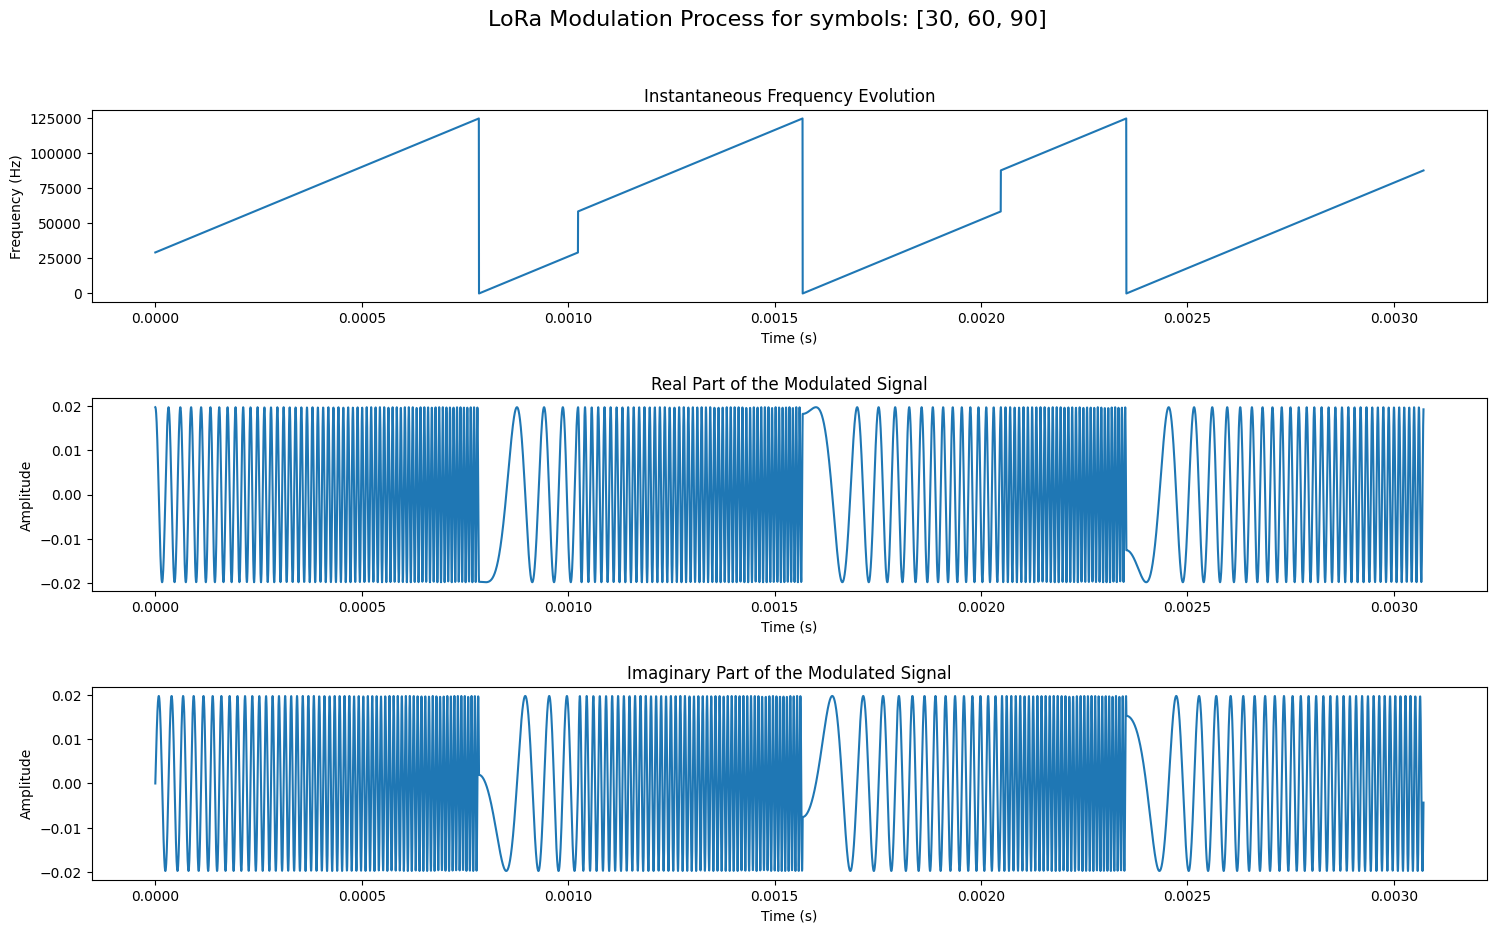

Synchronization started...
Phase 1: Searching for upchirps...
Phase 2: Ensuring that the candidate upchirp is a preamble member...
Preamble allegedly found at index:  2236
Phase 3: Refining synchronization index... (SPC > 1 requires it)
Offset quality measurements:  [1.         0.99605794 0.98397903 0.96395764 0.93629813 0.90140802
 0.85979098 0.81203987 0.75882948 0.70090836 0.        ]
Offset that ensures Highest Quality Synchronization:  0
Synchronization successful!
-----------------------------------------------------------
Preamble found at index:  2236
Refined by an offset of:  0
Package length:  3
Payload starts at index:  23356
Reconstructed preamble: [6 upchirps, 2 downchirps]


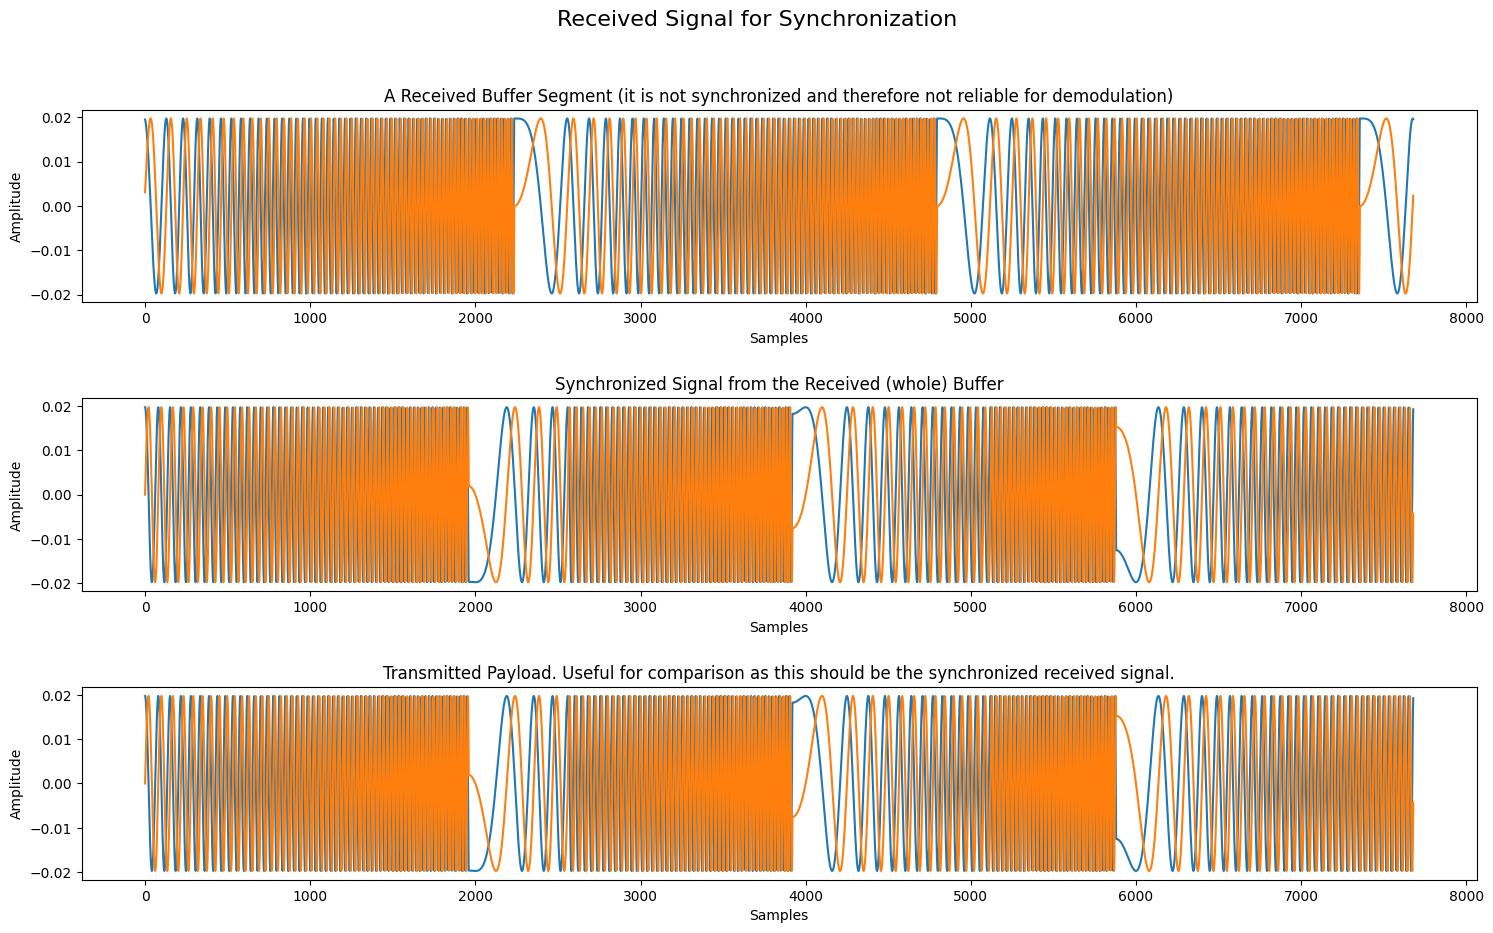

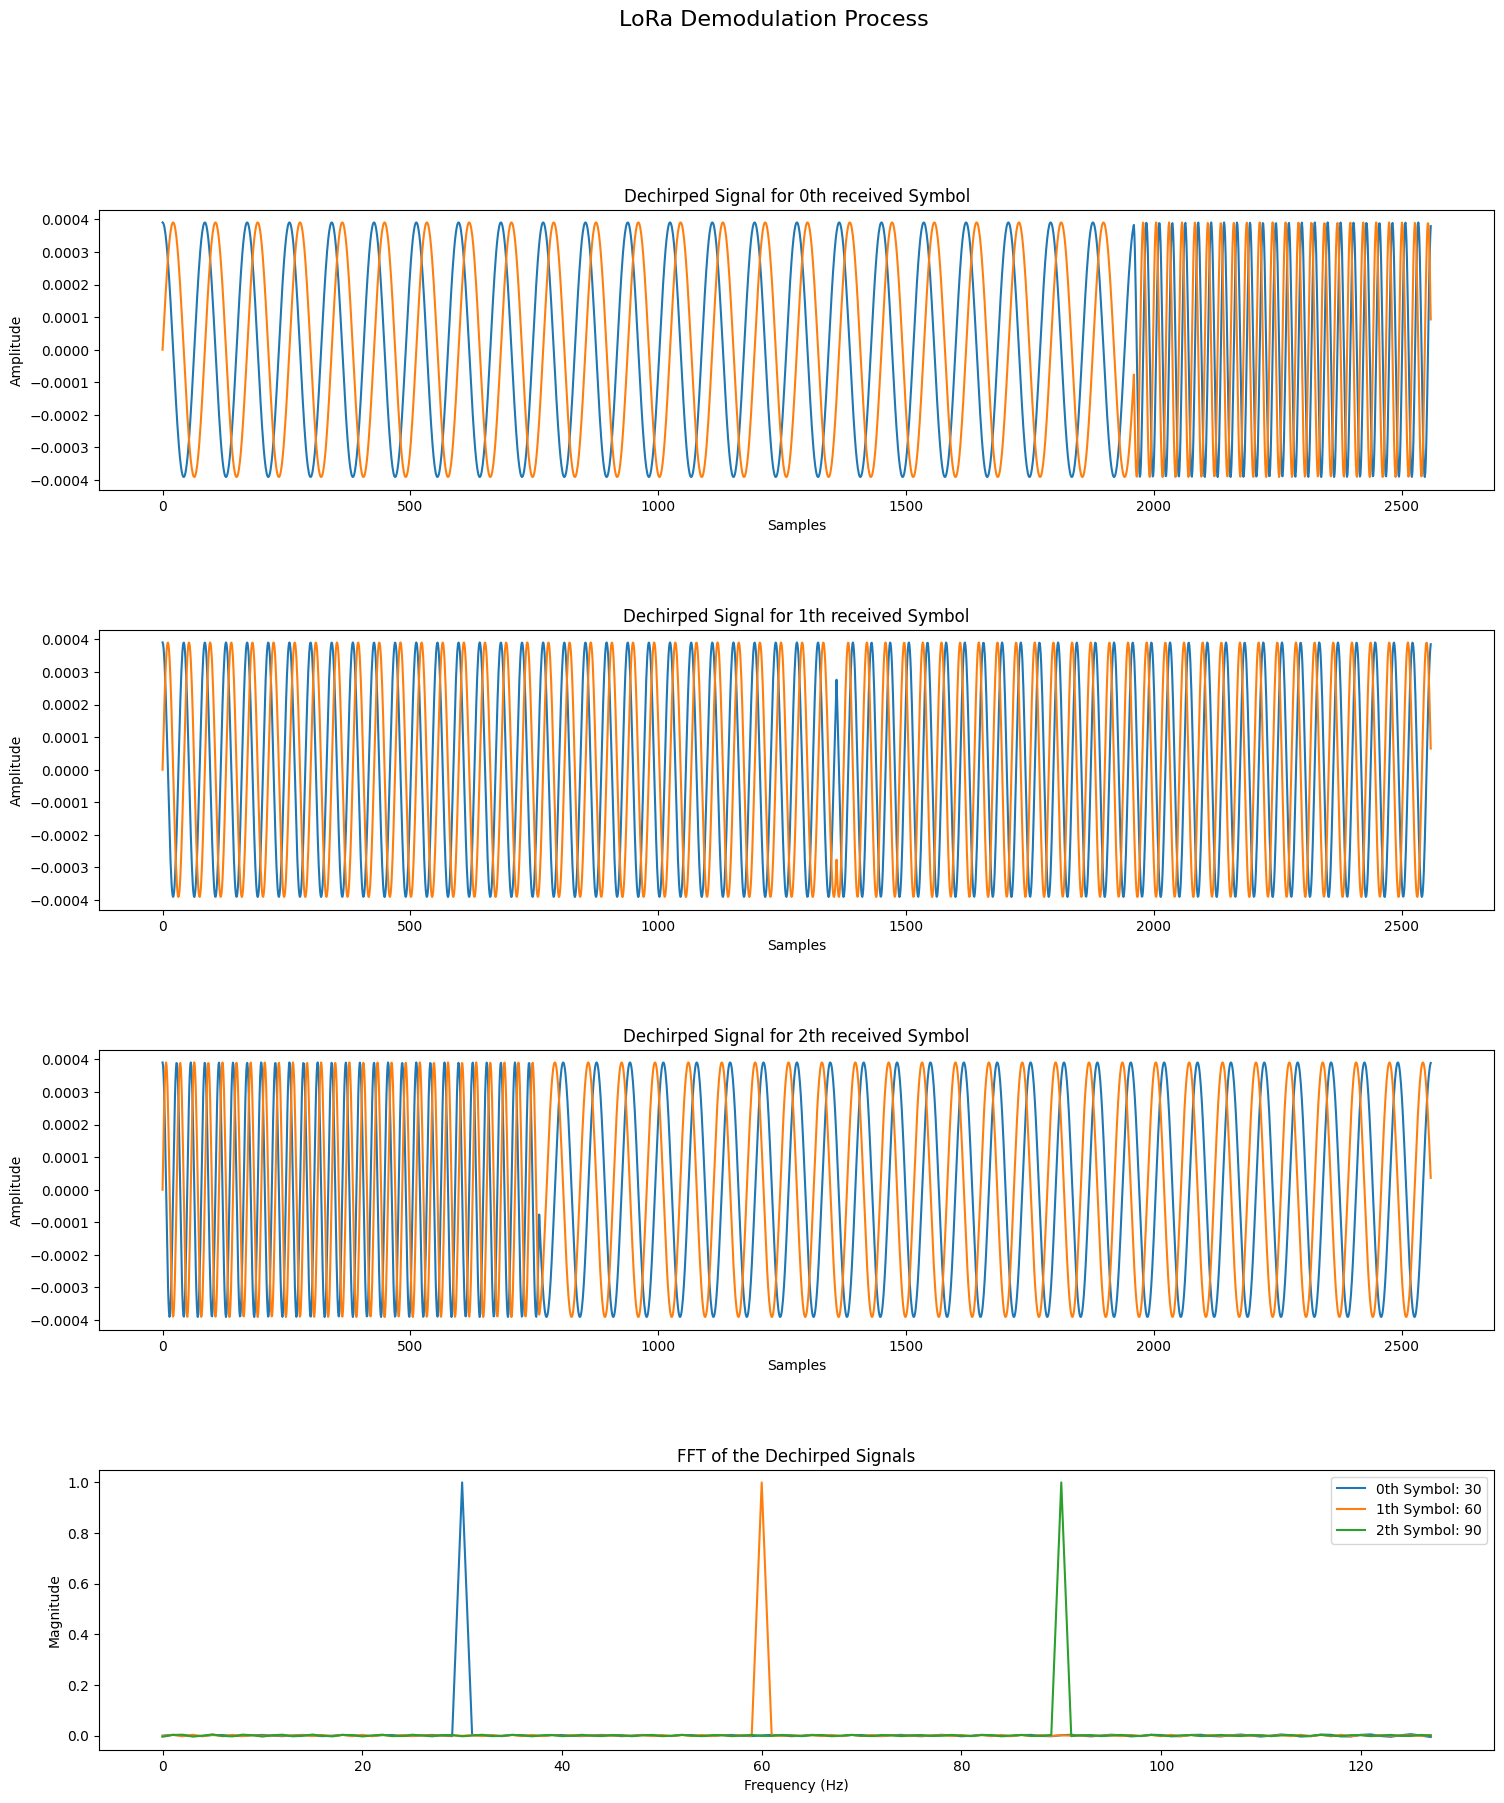

In [4]:
def ciclify(signal):
    """Shifts the signal in a cyclical nature to simulate a real-world scenario where the signal's first sample isn't alligned to the first received one."""
    rx_buffer = np.array([signal, signal, signal]).flatten()
    roll_factor = np.random.randint(0, len(rx_buffer)//2)
    rx_buffer = np.roll(rx_buffer, roll_factor)

    return rx_buffer


# ----- Playground -----
spreading_factor = 7
bandwidth = 125e3
samples_per_chip = 20
preamble_number = 8
payload = [30, 60, 90]

# Inicio el modulador, demodulador y sincronizador
modulator = LoraModulator(spreading_factor, bandwidth, samples_per_chip)
demodulator = LoraDemodulator(spreading_factor, bandwidth, samples_per_chip)
synchronizer = LoraOriginalSynchronizer(spreading_factor, samples_per_chip, demodulator, preamble_number)

# Modulo y ploteo el paquete para el payload especificado
pkg_signal, payload_signal = modulator.modulate_n_plot_explicit_package(preamble_number, payload, plot_with_preamble=False, return_payload_signal=True)

# "Ciclifico" el paquete para simular una recepción real de un SDR con transmisión de señal no alineada y cíclica
rx_buffer = ciclify(pkg_signal)

# Sincronizo el buffer recibido
sync_rx_payload = synchronizer.synchronize_rx_buffer(rx_buffer)

# Ploteo la sincronización
synchronizer.plot_synchronization(rx_buffer, sync_rx_payload, payload_signal)

if sync_rx_payload is not None:
    # Demodulo y ploteo los símbolos recibidos si la sincronización fue exitosa
    received_symbols = demodulator.demodulate_n_plot_symbols(sync_rx_payload)
    
